### Цель проекта

Разработать модель, предсказывающую стоимость авто на вторичном рынке. Метрикой оценки является MAPE - Mean Absolute Percentage Error.

#### Данные
train.csv - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.

test.csv - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.


vin - идентификатор автомобиля в тестовом наборе.

sellingprice - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости продажи.

#### Описание полей данных

Date: Год выпуска автомобиля.

Make: Марка автомобиля.

Model: издание автомобиля определенной марки.

Trim: Уровни отделки салона автомобиля — это просто разные версии модели.

Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.

Transmission: механизм, который передает мощность от двигателя к колесам.

VIN: идентификационный номер транспортного средства.

State: штаты.

Condition: Состояние автомобилей на момент аукциона.

Odometer: расстояние, пройденное автомобилем с момента выпуска.
Color: Цвет кузова автомобиля.

Interior: Цвет салона автомобиля.

Seller: Продавец автомобиля, автосалоны.

mmr: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.

sellingprice: цена, по которой автомобиль был продан на аукционе.

saledate: Дата продажи автомобиля.

### Загрузка данных

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyvin import VIN

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import make_scorer

from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Разведочный анализ данных.

Посмотрим машины какого года выпуска у нас есть.

In [3]:
data['year'].unique()

array([2011, 2014, 2012, 2003, 2007, 2013, 2010, 2000, 2005, 2006, 2004,
       2008, 2009, 2015, 2002, 2001, 1999, 1998, 1996, 1997, 1994, 1995,
       1993, 1989, 1991, 1988, 1987, 1990, 1992, 1985, 1986, 1983, 1984,
       1982], dtype=int64)

In [4]:
data['year'].min()

1982

In [5]:
data['year'].max()

2015

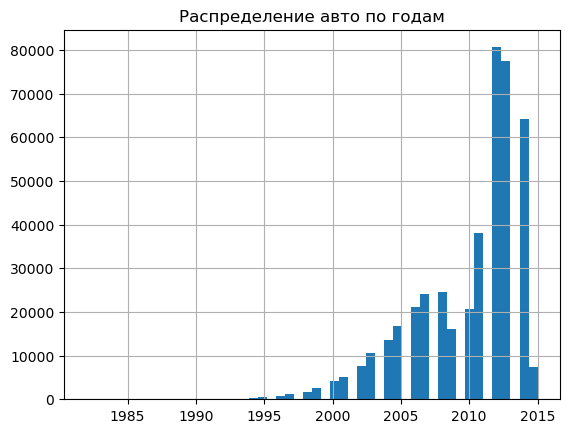

In [6]:
data['year'].hist(bins=50)
plt.title('Распределение авто по годам')
plt.show()

У нас есть машины с 1982 по 2015 годы выпуска. Большинство машин с 2010 до 2015 года выпуска, меньше всего с 1985 по 2000 годы.

Посмотрим на распредление цен на авто.

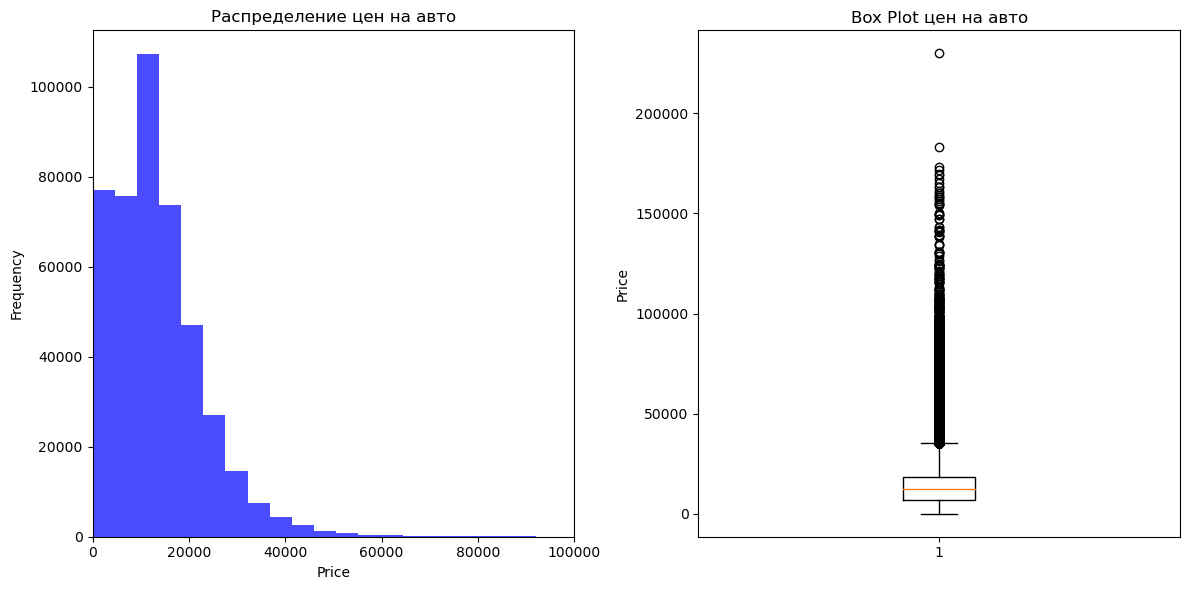

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(data['sellingprice'], bins=50, color='blue', alpha=0.7)
ax1.set_xlim(0, 100000)
ax1.set_title('Распределение цен на авто')
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')

ax2.boxplot(data['sellingprice'])
ax2.set_title('Box Plot цен на авто')
ax2.set_ylabel('Price')

plt.tight_layout()  
plt.show()


In [8]:
data['sellingprice'].describe()

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

Посмотрим какие авто самые дорогие.

In [9]:
data[data['sellingprice'] > 100000]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
3046,2014,Mercedes-Benz,G-Class,G63 AMG,SUV,automatic,wdcyc7df6ex216753,ca,5.0,980.0,charcoal,black,chings trading,134000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
6464,2013,Bentley,Continental GTC,Base,Convertible,automatic,scbgu3za2dc084880,ga,3.5,13840.0,gray,tan,porsche fin svcs dba bentley financial services,130500,Wed May 27 2015 03:00:00 GMT-0700 (PDT)
9787,2013,Mercedes-Benz,G-Class,G63 AMG,SUV,automatic,wdcyc7df5dx202289,ca,4.4,23663.0,gray,black,honda of pasadena,109000,Thu Feb 12 2015 04:30:00 GMT-0800 (PST)
12304,2014,Audi,RS 7,Prestige quattro,Sedan,automatic,wuaw2afc7en902024,ca,5.0,6526.0,black,black,kawo int'l inc,105000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
13149,2014,BMW,i8,Base,Coupe,automatic,wby2z2c50evx64103,ca,5.0,603.0,white,beige,high bid trading co inc,158000,Thu Feb 12 2015 04:00:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427614,2012,Ferrari,California,Base,convertible,automatic,zff65tja4c0187060,fl,4.2,8972.0,gray,black,the collection,138000,Thu May 28 2015 02:15:00 GMT-0700 (PDT)
431767,2014,Land Rover,Range Rover,Supercharged,SUV,automatic,salgs2ef7ea152790,ca,4.8,9968.0,black,black,high bid trading co inc,104000,Thu Feb 12 2015 04:00:00 GMT-0800 (PST)
432735,2010,Bentley,Continental Supersports,Base,Coupe,automatic,scbcu8za2ac064118,ca,3.2,5138.0,red,black,jn group inc,101000,Wed Jan 28 2015 10:00:00 GMT-0800 (PST)
438781,2014,Land Rover,Range Rover,Supercharged,SUV,automatic,salgs2ef7ea152398,ca,5.0,2282.0,black,black,land rover north america llc,110000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


Средняя стоимость автомобиля - 13592, максимальная - 230000б минимальная - 1.
Максимальная цена и наличие выбросов могут объясняться элитными марками - Bentley,Ferrari, Land Rover.

Данные распредлены неравномерно, дешевых машин до 15 000 больше всего, чем выше цена, тем меньше машин представленно в выборке.

Посмотрим также на данные по пробегу.

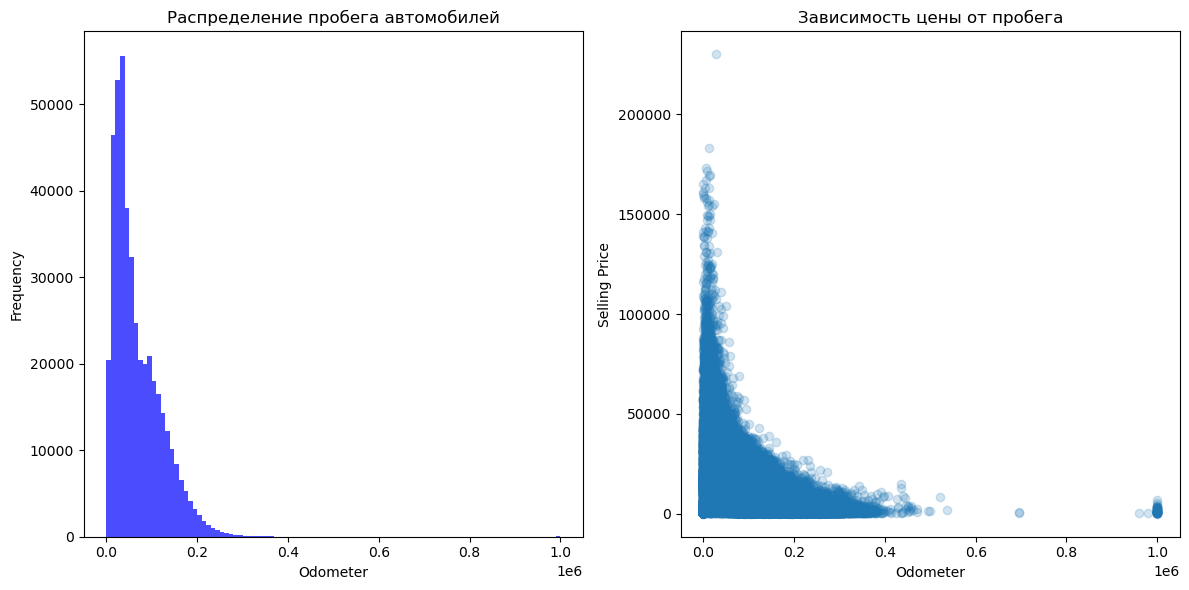

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(data['odometer'], bins=100, color='blue', alpha=0.7)
ax1.set_title('Распределение пробега автомобилей')
ax1.set_xlabel('Odometer')
ax1.set_ylabel('Frequency')

ax2.scatter(data["odometer"], data["sellingprice"], alpha=0.2)
ax2.set_title("Зависимость цены от пробега")
ax2.set_ylabel("Selling Price")
ax2.set_xlabel('Odometer')

plt.tight_layout()  
plt.show()

In [11]:
data['odometer'].describe()

count    440167.000000
mean      68344.421604
std       53542.203908
min           1.000000
25%       28258.000000
50%       52098.000000
75%       99272.000000
max      999999.000000
Name: odometer, dtype: float64

Средний пробег машин - 68344 миль. Видна зависимость стоимости машины от пробега, чем меньше пробег, тем выше стоимость.

Посмотрим на признак оценки состояния автомобиля по мнению владельца.

In [12]:
data['condition'].unique()

array([4.2, 3.5, 2.2, 2.8, 2. , 2.5, 3.4, 4.8, 1.9, 1. , 3.1, 2.7, 3.6,
       2.9, 4.1, 2.6, 2.1, 3. , 4.9, 4.7, 4. , 3.3, 3.8, 3.7, 4.5, 4.6,
       5. , 4.3, 2.4, 2.3, 3.9, nan, 3.2, 4.4, 1.4, 1.5, 1.7, 1.2, 1.3,
       1.6, 1.8, 1.1])

Округлим данные и построим столбчатую диаграмму.

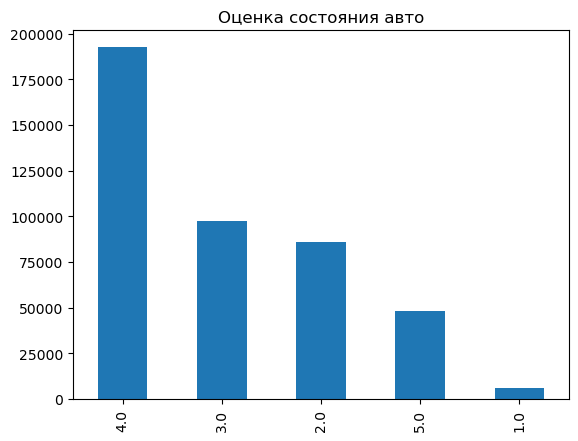

In [63]:
data['condition'].round().sort_values().value_counts().plot.bar()
plt.title('Оценка состояния авто')
plt.show()

Большинство машин находится в хорошем состоянии по мнению их владельцев. Меньше всего машин в очень плохом состоянии и в отличном.

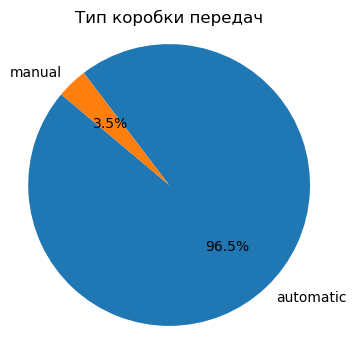

In [14]:
transmission_counts = data['transmission'].value_counts()

plt.figure(figsize=(4, 4))  
plt.pie(transmission_counts, labels=transmission_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Тип коробки передач')
plt.axis('equal')

plt.show()

Почти все машины на автоматической коробке передач.

Проверим датасет на дубликаты.

In [15]:
print ('Количество явных дубликатов:', data.duplicated().sum())
print ('Количество дубликатов по vin:',len(data[data.duplicated('vin')]))

Количество явных дубликатов: 0
Количество дубликатов по vin: 0


#### Вывод 

В данных машины с 1982 по 2015 годы выпуска. Большинство машин с 2010 до 2015 года выпуска, меньше всего с 1985 по 2000 годы.

Данные по цене распредлены неравномерно, дешевых машин до 15 000 больше всего, чем выше цена, тем меньше машин представленно в выборке.Средняя стоимость автомобиля - 13592, максимальная - 230000б минимальная - 1. Максимальная цена и наличие выбросов могут объясняться элитными марками - Bentley,Ferrari, Land Rover.

Средний пробег машин - 68344 миль. Видна зависимость стоимости машины от пробега, чем меньше пробег, тем выше стоимость.

Большинство машин находится в хорошем состоянии по мнению их владельцев. Меньше всего машин в очень плохом состоянии и в отличном.

Почти все машины на автоматической коробке передач.

Дубликатов не обнаружено.

### Заполним пропуски в данных

Посмотрим на пропуски в данных.

In [16]:
data.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [17]:
test.isna().sum()

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

Больше всего пропусков в признаках make, model, trim, body, transmission. Критически важными здесь являются make, model - тк ценообразование сильно зависит от марки и модели машины.

Призак trim отвечает за уровень отделки салона, а body за тип транспортного средства.
Эти признаки могут влиять на конечную стоимость, но не существенно.

С помощью библиотеки pyvin заполним пропуски в столбцах model, make в тренировочной и тестовой выборках.

In [18]:
for index, row in data.iterrows():
    if pd.isnull(row['make']):
        vin = row['vin']
        vin = vin.upper()
        try:
            find_make = VIN(vin)
            find_make = find_make.Make
            data.loc[index, 'make'] = find_make
        except Exception as e:
            print(f"Error decoding VIN for index {index}: {e}")


data.to_csv('data.csv', index=False)

##### Заполняем пропуски в модели в тернировочной выборке.

In [19]:
%%time

for index, row in data.iterrows():
    if pd.isnull(row['model']):
        vin = row['vin']
        vin = vin.upper()
        try:
            find_model = VIN(vin)
            find_model = find_model.Model
            data.loc[index, 'model'] = find_model
        except Exception as e:
            print(f"Error decoding VIN for index {index}: {e}")


data.to_csv('data.csv', index=False)

Функциями выше заполнили пропуски и сохранили получившийся датафрейм в новый файл, чтобы не запускать их по новой каждый раз.

In [20]:
data = pd.read_csv('df_last.csv')

##### Заполняем пропуски в марке в тестовой выборке.

In [21]:
for index, row in test.iterrows():
    if pd.isnull(row['make']):
        vin = row['vin']
        vin = vin.upper()
        try:
            find_make = VIN(vin)
            find_make = find_make.Make
            test.loc[index, 'make'] = find_make
        except Exception as e:
            print(f"Error decoding VIN for index {index}: {e}")

test.to_csv('test_filled1.csv', index=False)

##### Заполняем пропуски в модели в тестовой выборке.

In [22]:
%%time

for index, row in test.iterrows():
    if pd.isnull(row['model']):
        vin = row['vin']
        vin = vin.upper()
        try:
            find_model = VIN(vin)
            find_model = find_model.Model
            test.loc[index, 'model'] = find_model
        except Exception as e:
            print(f"Error decoding VIN for index {index}: {e}")


test.to_csv('test_filled1.csv', index=False)

Функциями выше заполнили пропуски и сохранили получившийся датафрейм в новый файл, чтобы не запускать их по новой каждый раз.

In [23]:
test = pd.read_csv('test_filled1.csv')

В тренировочной выборке удалось восстановить 8034 марки и 8066 модели.

В тестовой удалось восстановить 2060 марки и 2064 модели.

Обработаем полученные значения и приведем их к одному формату, удалим дубликаты.

In [24]:
data['make'] = data['make'].str.lower()
data['make'] = data['make'].str.replace('vw', 'volkswagen')

data['make'] = data['make'].str.replace('mercedes-b',  'mercedes')
data['make'] = data['make'].str.replace('mercedes-benz',  'mercedes')
data['make'] = data['make'].str.replace('mercedesenz',  'mercedes')
data['make'] = data['make'].str.replace('ford truck',  'ford')
data['make'] = data['make'].str.replace('gmc truck',  'gmc')
data['make'] = data['make'].str.replace('dodge tk',  'dodge')
data['make'] = data['make'].str.replace('mazda tk',  'mazda')
data['make'] = data['make'].str.replace('landrover',  'land rover')

In [25]:
test['make'] = test['make'].str.lower()
test['make'] = test['make'].str.replace('vw', 'volkswagen')

test['make'] = test['make'].str.replace('mercedes-b',  'mercedes')
test['make'] = test['make'].str.replace('mercedes-benz',  'mercedes')
test['make'] = test['make'].str.replace('mercedesenzb',  'mercedes')
test['make'] = test['make'].str.replace('mercedes-benz',  'mercedes')
test['make'] = test['make'].str.replace('ford tk',  'ford')
test['make'] = test['make'].str.replace('hyundai tk',  'hyundai')
test['make'] = test['make'].str.replace('chev truck',  'chevrolet')

In [26]:
data['model'] = data['model'].str.lower()
test['model'] = test['model'].str.lower()

In [27]:
print ("Количество марок в тернировочной выборке:", len(data['make'].unique()))
print ("Количество марок в тестовой выборке:", len(test['make'].unique()))
print ("Количество моделей в тернировочной выборке:", len(data['model'].unique()))
print ("Количество моделей в тестовой выборке:", len(test['model'].unique()))


Количество марок в тернировочной выборке: 56
Количество марок в тестовой выборке: 56
Количество моделей в тернировочной выборке: 879
Количество моделей в тестовой выборке: 780


Сделаем такую же обработку для типа кузова.

In [28]:
data['body'].sort_values().unique()

array(['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon',
       'CTS-V Coupe', 'CTS-V Wagon', 'Cab Plus', 'Cab Plus 4', 'Club Cab',
       'Convertible', 'Coupe', 'Crew Cab', 'CrewMax Cab', 'Double Cab',
       'E-Series Van', 'Elantra Coupe', 'Extended Cab', 'G Convertible',
       'G Coupe', 'G Sedan', 'G37 Convertible', 'G37 Coupe',
       'Genesis Coupe', 'GranTurismo Convertible', 'Hatchback',
       'King Cab', 'Koup', 'Mega Cab', 'Minivan', 'Promaster Cargo Van',
       'Q60 Convertible', 'Q60 Coupe', 'Quad Cab', 'Ram Van',
       'Regular Cab', 'SUV', 'Sedan', 'SuperCab', 'SuperCrew',
       'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon', 'Xtracab',
       'access cab', 'beetle convertible', 'cab plus 4', 'club cab',
       'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe',
       'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe',
       'extended cab', 'g convertible', 'g coupe', 'g sedan',
       'g37 convertible', 'g37 coupe', 'genesis c

In [29]:
data['body'] = data['body'].str.lower()

In [30]:
test['body'].sort_values().unique()

array(['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon',
       'CTS-V Coupe', 'Cab Plus', 'Club Cab', 'Convertible', 'Coupe',
       'Crew Cab', 'CrewMax Cab', 'Double Cab', 'E-Series Van',
       'Elantra Coupe', 'Extended Cab', 'G Convertible', 'G Coupe',
       'G Sedan', 'G37 Convertible', 'G37 Coupe', 'Genesis Coupe',
       'GranTurismo Convertible', 'Hatchback', 'King Cab', 'Koup',
       'Mega Cab', 'Minivan', 'Promaster Cargo Van', 'Q60 Convertible',
       'Q60 Coupe', 'Quad Cab', 'Regular Cab', 'SUV', 'Sedan', 'SuperCab',
       'SuperCrew', 'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon',
       'Xtracab', 'access cab', 'club cab', 'convertible', 'coupe',
       'crew cab', 'crewmax cab', 'cts coupe', 'cts-v coupe',
       'double cab', 'e-series van', 'elantra coupe', 'extended cab',
       'g convertible', 'g coupe', 'g sedan', 'genesis coupe',
       'granturismo convertible', 'hatchback', 'king cab', 'koup',
       'mega cab', 'minivan', 'promaster cargo v

In [31]:
test['body'] = test['body'].str.lower()

In [32]:
test['body'].sort_values().unique()

array(['access cab', 'beetle convertible', 'cab plus', 'club cab',
       'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe',
       'cts wagon', 'cts-v coupe', 'double cab', 'e-series van',
       'elantra coupe', 'extended cab', 'g convertible', 'g coupe',
       'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe',
       'granturismo convertible', 'hatchback', 'king cab', 'koup',
       'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible',
       'q60 coupe', 'quad cab', 'regular cab', 'regular-cab', 'sedan',
       'supercab', 'supercrew', 'suv', 'transit van', 'tsx sport wagon',
       'van', 'wagon', 'xtracab', nan], dtype=object)

Видим, что все значения можно свести к 9 основным: cab, convertible, coupe, wagon, van, sedan, hatchback, minivan, suv.

In [33]:
mapping = {
    'cab': ['access cab', 'cab plus', 'club cab', 'crew cab', 'crewmax cab',
            'double cab', 'king cab', 'mega cab', 'quad cab', 'regular cab', 'regular-cab', 'supercrew', 'supercab', 'xtracab'],
    'convertible': ['beetle convertible', 'convertible', 'g convertible', 'g37 convertible', 'granturismo convertible', 'q60 convertible'],
    'coupe': ['coupe', 'cts coupe', 'cts-v coupe', 'elantra coupe', 'g coupe', 'q60 coupe'],
    'wagon': ['cts wagon', 'tsx sport wagon', 'wagon'],
    'van': ['e-series van', 'promaster cargo van', 'transit van', 'van'],
    'sedan': ['g sedan', 'sedan'],
    'hatchback': ['hatchback'],
    'minivan': ['minivan'],
    'suv': ['suv']
}


def map_body_to_group(body_type):
    for group, body_list in mapping.items():
        if body_type in body_list:
            return group
    return 'Other'

test['group'] = test['body'].apply(map_body_to_group)
data['group'] = data['body'].apply(map_body_to_group)

In [34]:
test = test.drop('body', axis=1)
data = data.drop('body', axis=1)

Приведем trim к одному формату.

In [35]:
data['trim'] = data['trim'].str.lower()
test['trim'] = test['trim'].str.lower()

In [36]:
data['transmission'].value_counts()

automatic    375061
manual        13714
Name: transmission, dtype: int64

In [37]:
test['transmission'].value_counts()

automatic    93584
manual        3463
Name: transmission, dtype: int64

в 90% случаев коробка передач автоматическая. Заменим пропуски в данных на автомат.

In [38]:
data['transmission'] = data['transmission'].fillna('automatic')
test['transmission'] = test['transmission'].fillna('automatic')

In [39]:
data['transmission'].value_counts()

automatic    426522
manual        13714
Name: transmission, dtype: int64

In [40]:
data.isna().sum()

year               0
model             57
trim            3014
transmission       0
vin                0
state              0
condition       9405
odometer          59
color            586
interior         586
seller             0
sellingprice       0
saledate           0
make               9
group              0
dtype: int64

#### Вывод

Больше всего пропусков в признаках make, model, trim, body, transmission. Критически важными здесь являются make, model - тк ценообразование сильно зависит от марки и модели машины.
Призак trim отвечает за уровень отделки салона, а body за тип транспортного средства. Эти признаки могут влиять на конечную стоимость, но не существенно.

С помощью библиотеки pyvin заполнили пропуски в столбцах model, make в тренировочной и тестовой выборках.

В тренировочной выборке удалось восстановить 8034 марки и 8066 модели.

В тестовой удалось восстановить 2060 марки и 2064 модели.

Привели к одному виду марки и модели:
- количество марок в тернировочной выборке: 56
- количество марок в тестовой выборке: 56
- количество моделей в тернировочной выборке: 879
- количество моделей в тестовой выборке: 780

Сделали такую же обработку для типа кузова.И свели к 9 основным: cab, convertible, coupe, wagon, van, sedan, hatchback, minivan, suv.

Заменили пропуски в данных по коробке передач на автомат.

### Создаем новые признаки

Временные признаки, созданные из даты.

In [41]:
data = data.drop(['vin'],axis=1)
data['saledate'] = pd.to_datetime(data['saledate'], utc=True)
# создаем признак с годом продажи
data['sale_year'] = data['saledate'].dt.year
# создаем признак с возрастом машины
data['age_of_car'] = data['sale_year'] - data['year']
data = data.drop(['saledate', 'sale_year'], axis=1)

In [42]:
test = test.drop(['vin'],axis=1)
# переводим строку в формат даты
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)
# создаем признак с годом продажи
test['sale_year'] = test['saledate'].dt.year
# создаем признак с возрастом машины
test['age_of_car'] = test['sale_year'] - test['year']
test = test.drop(['saledate', 'sale_year'], axis=1)

Признак, созданный из стоимости.

In [43]:
average_prices = data.groupby('make')['sellingprice'].mean()
average_price_dict = average_prices.to_dict()
data['avg_price_make'] = data.apply(lambda row: average_price_dict.get(row['make'], 0), axis=1)
test['avg_price_make'] = test.apply(lambda row: average_price_dict.get(row['make'], 0), axis=1)


### Протестируем на тренировочных данных модели.

Готовим признаки.

In [44]:
features = data.drop(['sellingprice'],axis=1)
target = data['sellingprice']

In [45]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                           test_size=0.33, random_state=123)

In [46]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            440236 non-null  int64  
 1   model           440179 non-null  object 
 2   trim            437222 non-null  object 
 3   transmission    440236 non-null  object 
 4   state           440236 non-null  object 
 5   condition       430831 non-null  float64
 6   odometer        440177 non-null  float64
 7   color           439650 non-null  object 
 8   interior        439650 non-null  object 
 9   seller          440236 non-null  object 
 10  make            440227 non-null  object 
 11  group           440236 non-null  object 
 12  age_of_car      440236 non-null  int64  
 13  avg_price_make  440236 non-null  float64
dtypes: float64(3), int64(2), object(9)
memory usage: 47.0+ MB


In [47]:
# перечислили категориальные переменные
categorical_features = ['model', 'trim', 'group', 'make', 'state', 'color', 'interior', 'seller', 'transmission']
# кодируем с помощью LabelEncoder
encoder = OrdinalEncoder(handle_unknown ='use_encoded_value', unknown_value=np.nan)
features_train[categorical_features] = encoder.fit_transform(features_train[categorical_features])
features_test[categorical_features] = encoder.transform(features_test[categorical_features])

In [48]:
numeric = ['year', 'age_of_car', 'condition', 'odometer',]
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [49]:
features_train= features_train.fillna(0)
features_test = features_test.fillna(0)

#### Модель LogisticRegression.

In [50]:
model_regress = LogisticRegression( )

In [51]:
model_regress.fit(features_train, target_train)

C:\Users\frolo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [52]:
prediction_model_regress = model_regress.predict(features_test)

In [53]:
mape_regress = mean_absolute_percentage_error(target_test, prediction_model_regress)
print ("MAPE LogisticRegression", mape_regress)

MAPE LogisticRegression 1.6400738857341046


#### Модель Random Forest 

In [54]:
rf_regressor = RandomForestRegressor(random_state=42)

In [55]:
rf_regressor.fit(features_train, target_train)

RandomForestRegressor(random_state=42)

In [56]:
rf_prediction = rf_regressor.predict(features_test)
mae_rf = mean_absolute_percentage_error(target_test, rf_prediction)
print ('MAPE Random Forest:' ,mae_rf)

MAPE Random Forest: 0.20516732030156348


#### Модель Catboost.

In [57]:
categorical = ['make', 'model', 'trim', 'group', 'state', 'color',
               'transmission', 'interior', 'seller', 'condition']

In [58]:
features_train[categorical]= features_train[categorical].astype('str')
features_test[categorical]= features_test[categorical].astype('str')

In [59]:
model1_cat = CatBoostRegressor(cat_features = categorical, depth = 10)

In [60]:
model1_cat.fit(features_train, target_train)

Learning rate set to 0.100555
0:	learn: 9060.2621833	total: 619ms	remaining: 10m 18s
1:	learn: 8425.7843016	total: 1.09s	remaining: 9m 5s
2:	learn: 7856.6030537	total: 1.57s	remaining: 8m 41s
3:	learn: 7352.2086983	total: 2.07s	remaining: 8m 34s
4:	learn: 6897.1023125	total: 2.67s	remaining: 8m 50s
5:	learn: 6477.5926762	total: 3.14s	remaining: 8m 40s
6:	learn: 6110.1058783	total: 3.58s	remaining: 8m 28s
7:	learn: 5800.9178400	total: 4.15s	remaining: 8m 34s
8:	learn: 5536.3119810	total: 4.66s	remaining: 8m 33s
9:	learn: 5289.1662433	total: 5.12s	remaining: 8m 26s
10:	learn: 5080.7892926	total: 5.68s	remaining: 8m 30s
11:	learn: 4875.9880556	total: 6.12s	remaining: 8m 23s
12:	learn: 4722.3245652	total: 6.62s	remaining: 8m 22s
13:	learn: 4547.4859278	total: 7.13s	remaining: 8m 21s
14:	learn: 4420.8752146	total: 7.66s	remaining: 8m 23s
15:	learn: 4290.7882655	total: 8.22s	remaining: 8m 25s
16:	learn: 4173.2991493	total: 8.85s	remaining: 8m 31s
17:	learn: 4064.0294589	total: 9.41s	remainin

In [61]:
prediction_model1_cat = model1_cat.predict(features_test)
mape_cat1 = mean_absolute_percentage_error(target_test, prediction_model1_cat)
print ('MAPE Catboost:', mape_cat1)

MAPE Catboost: 0.22483118157614254


#### Вывод:
Лучшая модель - Catboost, с метрикой 0.22  и гиперпараметром max_depth=10
Линейная Регрессия не справилась с предсказаниями 1.6
Случайны лес выдал MAPE 0.20

#### Модель Catboost на тестовой выборке.

In [78]:
features = data.drop(['sellingprice'],axis=1)
target = data['sellingprice']

In [79]:
categorical = ['make', 'model', 'trim', 'group', 'state', 'color',
               'transmission', 'interior', 'seller', 'condition']

In [80]:
labels = list(features.columns.values)

In [81]:
list(features)

['year',
 'model',
 'trim',
 'transmission',
 'state',
 'condition',
 'odometer',
 'color',
 'interior',
 'seller',
 'make',
 'group',
 'age_of_car',
 'avg_price_make']

In [82]:
desired_order =['year',
 'model',
 'trim',
 'transmission',
 'state',
 'condition',
 'odometer',
 'color',
 'interior',
 'seller',
 'make',
 'group',
 'age_of_car',
 'avg_price_make'
 ]

test = test[desired_order]

In [83]:
test[categorical]= test[categorical].astype('str')
features[categorical]= features[categorical].astype('str')

In [84]:
%%time

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


param_grid_cat = { 'depth': [10]
}

catboost_model = CatBoostRegressor(
    cat_features=categorical,
    random_state=42,
    verbose=True
)

custom_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
grid_search = GridSearchCV(
    catboost_model,
    param_grid=param_grid_cat,
    scoring=custom_scorer,  
    n_jobs=-1, 
    verbose=5
)


grid_search.fit(features, target)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

mape = -grid_search.best_score_  
print("Best Parameters:", best_params)
print("Mean Absolute Percentage Error on Test Data:", mape)
print(best_params, best_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.107123
0:	learn: 9001.9455741	total: 839ms	remaining: 13m 57s
1:	learn: 8324.8492889	total: 1.53s	remaining: 12m 46s
2:	learn: 7710.9895238	total: 2.11s	remaining: 11m 42s
3:	learn: 7182.2370095	total: 2.9s	remaining: 12m 2s
4:	learn: 6723.1481594	total: 3.72s	remaining: 12m 20s
5:	learn: 6316.1262286	total: 4.41s	remaining: 12m 10s
6:	learn: 5980.0502531	total: 5.13s	remaining: 12m 7s
7:	learn: 5645.5320419	total: 5.84s	remaining: 12m 4s
8:	learn: 5375.7968093	total: 6.51s	remaining: 11m 56s
9:	learn: 5130.8029669	total: 7.29s	remaining: 12m 1s
10:	learn: 4896.4063161	total: 8.01s	remaining: 11m 59s
11:	learn: 4719.4661477	total: 8.67s	remaining: 11m 53s
12:	learn: 4542.8632657	total: 9.23s	remaining: 11m 40s
13:	learn: 4395.2322683	total: 9.98s	remaining: 11m 43s
14:	learn: 4268.7785108	total: 10.7s	remaining: 11m 43s
15:	learn: 4140.7356557	total: 11.4s	remaining: 11m 42s
16:	learn: 4039.8706272	total:

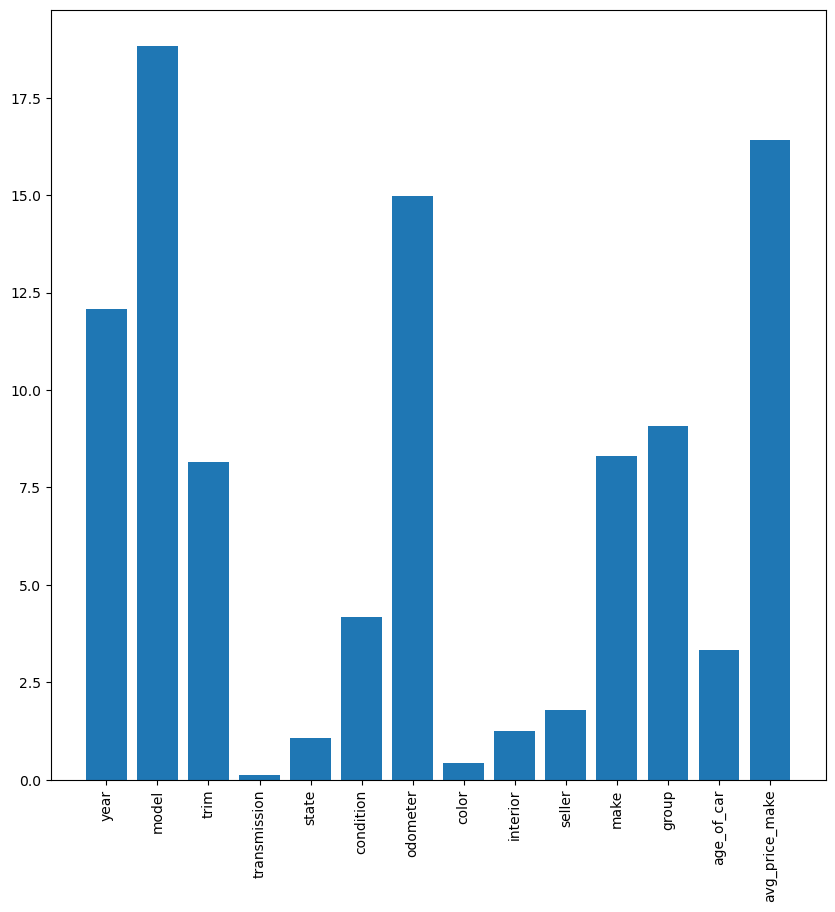

In [88]:
plt.figure(figsize=(10,10))
plt.bar(labels, best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [85]:
result3= best_model.predict(test)

In [87]:
import csv
vins = pd.read_csv('test.csv')
vins = vins['vin']

combined_data = list(zip(vins, result3))
csv_file_path = "predictions.csv"

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["vin", "sellingprice"])
    writer.writerows(combined_data)


## Общий вывод

#### На этапе развдочного анализа данных были сделаны следующий выводы:

В данных машины с 1982 по 2015 годы выпуска. Большинство машин с 2010 до 2015 года выпуска, меньше всего с 1985 по 2000 годы.

Данные по цене распредлены неравномерно, дешевых машин до 15 000 больше всего, чем выше цена, тем меньше машин представленно в выборке.Средняя стоимость автомобиля - 13592, максимальная - 230000б минимальная - 1. Максимальная цена и наличие выбросов могут объясняться элитными марками - Bentley,Ferrari, Land Rover.

Средний пробег машин - 68344 миль. Видна зависимость стоимости машины от пробега, чем меньше пробег, тем выше стоимость.

Большинство машин находится в хорошем состоянии по мнению их владельцев. Меньше всего машин в очень плохом состоянии и в отличном.

Почти все машины на автоматической коробке передач.

Дубликатов не обнаружено.

#### На этапе обработки признаков, было сделано:

С помощью библиотеки pyvin заполнили пропуски в столбцах model, make в тренировочной и тестовой выборках.В тренировочной выборке удалось восстановить 8034 марки и 8066 модели. В тестовой удалось восстановить 2060 марки и 2064 модели.
Привели к одному виду марки и модели: количество марок в тернировочной выборке: 56, количество марок в тестовой выборке: 56, количество моделей в тернировочной выборке: 879, количество моделей в тестовой выборке: 780. Сделали такую же обработку для типа кузова.И свели к 9 основным: cab, convertible, coupe, wagon, van, sedan, hatchback, minivan, suv.

Заменили пропуски в данных по коробке передач на автомат.


#### На этапе создания признаков: 

Создали синтетический признак с возрастом машины, средней стоимости по марке машины.

#### На этапе разработки модели:

Было протестировано 3 модели: Linear Regressor, Random Forest Regressor, Catboost Regressor. 
Лучшую метрику выдал Catboost. 

На тестовых данных с помощью кросс валидации и гиперпараметрами max_depth = 10, была достигнула метрика MAPE 15.52.

Наиболее важными прзнаками оказались марка машины, пробег, год выпуска и средняя стоимость марки машины.
